In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from collections import defaultdict
from numpy.polynomial import Polynomial
from scipy.optimize import curve_fit
import numpy as np
from numpy.polynomial import Polynomial
import seaborn as sns
from pymoo.indicators.hv import HV
import os
import scikit_posthocs as sp
import traceback

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.style.use('seaborn')

/tmp/ipykernel_1190639/3527511527.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
max_expr_size = None
max_gen = None
max_size = 10
max_complexity = 1

dataset_filename_fronts = defaultdict(lambda: defaultdict(list))

translation_dict = {
"SO":"SO",
"MO": "MO",
"MO_equalclustersize": "5 x population size",
"MO_balanced": "Balanced k-leader",
"MO_k2": "Balanced k-2-Leader",
"MO_frac1": "Restricted Donor Population",
"MO_equalclustersize_balanced_frac1": "",
"MO_equalclustersize_k2_frac1": "Balanced k-2-Leader restricted donor population",
"MO_equalclustersize_k2_frac1_noadf":"",
"MO_equalclustersize_balanced_discount":"",
"MO_equalclustersize_balanced_frac1_discount":"",
"MO_equalclustersize_k2_noadf":"",
"MO_equalclustersize_k2":"",
"MO_equalclustersize_balanced":"",
"MO_equalclustersize_frac1":"",
"tree_7":"",
"tree_42":"",
"tree_44":"",
"MO_nocluster": "MO without clustering",
"MO_k2_frac1":"MO_k2_frac1"
}

In [4]:


def statistics_latex(hv_list, dataset, appendix):
    try:
        print("#"*20, dataset, appendix, "#"*20)
        print(sorted(list(hv_list.keys())))

        stri = ""
        for x in ["{0:.3f} $\\pm$ {1:.3f}".format(np.mean(hv_list[k]), np.std(hv_list[k])) for k in sorted(list(hv_list.keys()))]:
            stri += x + " & "
        print(stri)
        
        print([len(hv_list[k][0]) for k in sorted(list(hv_list.keys()))])
        x = sp.posthoc_wilcoxon([hv_list[k][0] for k in sorted(list(hv_list.keys()))], p_adjust="Holm")
        print(x)
        print("#"*20)
        return x
    except Exception as e:
        print("stats", e)
        pass

def statistics(hv_list, dataset, appendix):
    print("#"*20, dataset, appendix, "#"*20)

    for k in hv_list.keys():
        print(k, np.mean(hv_list[k]))


def make_plots(d, folder, x_index, appendix):
    
    for el in experiments:
        fig = plt.figure()
        plt.title("Dataset: {}".format(dataset.capitalize()))
        markers = ['o', 'x', '^','s']
        x = []

        hv_list = defaultdict(list)

        for key in d.keys():
            if key in el:
                x = d[key][x_index]
                y = d[key][1]

                gens = np.mean(d[key][2])
                
                print(x_index, max_size, max_complexity)
                #hvs = calc_hv(dataset_filename_fronts, dataset, key, x_index, max_size)
                hvs = calc_hv_3d(dataset_filename_fronts, dataset, key, x_index, max_size, max_complexity)
                
                print(hvs)

                hv_list[key].append(hvs)

                coefficients = np.polyfit(x, y, deg=5)  # Adjust the degree of polynomial as needed
                poly = np.poly1d(coefficients)

                # Generate points for the fitted curve
                x_fit = np.linspace(min(x), max(x), 1000)
                y_fit = poly(x_fit)


                # Plot scatter plot and line plot
                color = sns.color_palette()[int(el.index(key))]  # Get color from tab10 colormap
                marker = markers[int(el.index(key))]
                
                print("MEAN ", key, np.mean(hvs))

                plt.scatter(x, y, alpha=0.4, s=18, label=translation_dict[key] + " Average HV={0:.3f}, \n Average generations={1:.1f}".format(np.mean(hvs), gens), color=color, marker=marker)
                #plt.plot(x_fit, y_fit, c=color, alpha=0.5)

                # Commented out, because extreme slow
                # print("nondom")
                # nondom_list_x, nondom_list_y = non_dom(x,y)
                # plt.plot(nondom_list_x, nondom_list_y, linestyle='--', c=color,alpha=0.5)
                # print("done")

        statistics(hv_list, dataset, appendix)      

        if(len(x)>0):
            plt.xlim(0.5,None)
            plt.xlabel(r'$R^2$')
            plt.ylabel('Expression size')
            # plt.yscale('log', base=5)
            plt.legend()
            fig.set_size_inches(10, 10)

            #plt.gca().set_aspect('equal')

            directory = "./results/plots/" + folder
            isExist = os.path.exists(directory)
            if not isExist:
                os.makedirs(directory)

            if max_gen is None:
                plt.savefig(directory + "/{}_{}.png".format(dataset + "".join(el), appendix), dpi=600, bbox_inches='tight')
            else:
                plt.savefig(directory + "/{}_{}gen_{}.png".format(dataset + "".join(el), max_gen, appendix), dpi=600, bbox_inches='tight')
            plt.show()
        plt.close()

def get_mses(d, folder, x_index, appendix):
    pass





In [5]:
def get_significantly_better_index(meds):
    df = ((sp.posthoc_wilcoxon(meds, p_adjust="Holm", zero_method="zsplit") < 0.05).astype(int).sum()==(len(meds)-1)).astype(int)
    new_df = df

    for index, row in df.items():

        if row>0:
            
            if (np.median(meds[index-1])>[np.median(meds[(index + i) % (len(meds))]) for i in range(len(meds)-1)]).all():
                new_df.iloc[index-1] = 1
            else:
                new_df.iloc[index-1] = 0

    best_index = np.argwhere(new_df.to_numpy()>0)
    
    if len(best_index)>0:
        
        return best_index[0][0]
    return None

def get_hv(x,y,z, min_x, max_x, min_y, max_y, min_z, max_z, min_mse, max_mse, mse_mode=False, third_objective=False):
    min_x = 0
    max_x = 1.
    
    if mse_mode:
        x_array = (np.array(x)-min_mse)/(max_mse-min_mse)
    else:
        try:
            x_array = (np.array(x)-min_x)/(max_x-min_x)
        except:
            print(x)
            print(np.array(x))
        x_array = 1.-np.maximum(x_array,0.)

    y_array = (np.array(y)-min_y)/(max_y-min_y)
    z_array = (np.array(z)-min_z)/(max_z-min_z)

    if third_objective:
        result = np.column_stack((x_array, z_array))
    else:
        result = np.column_stack((x_array, y_array))

    ref_point = np.array([1., 1.])
    
#     if third_objective:
#         result = np.column_stack((x_array, y_array, z_array))

#         ref_point = np.array([1., 1., 1.])

    ind = HV(ref_point=ref_point)

    return ind(result)

def get_hvs(x, y, z, min_x, max_x, min_y, max_y, min_z, max_z, min_mse, max_mse, mse_mode=False, third_objective=False):
    hvs = []
    for x_val, y_val, z_val in zip(x,y,z):
        hvs.append(get_hv(x_val, y_val, z_val, min_x, max_x, min_y, max_y, min_z, max_z, min_mse, max_mse, mse_mode, third_objective))
    return hvs

def collapse_list(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

In [8]:
datasets = ["air","bike","concrete","dowchemical","tower"]

def get_dict(experiments, min_x=999999999., max_x = 0., max_gen = None):    
    
    min_y = 999999999.
    max_y = 0.
    min_z = 999999999.
    max_z = 0.
    
    max_mse = 0.
    min_mse = 999999999999.
    

    dataset_filename = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

    for dataset in datasets:
        folder = "joecomplexity"
        dir = "./results/" + folder
        for filename in sorted(glob.glob(dir + "/*.csv")):
            # Repetition number
            nr = int(filename.split("/")[-1].split("_")[0])
            # Dictionary key, e.g. SO_512
            d_key = "_".join(filename.split("/")[-1].split("_")[1:]).replace(dataset,"").replace(".csv","")[:-1]

            # Skip if not part of experiments
            if d_key not in experiments:
                continue

            if(dataset in filename):

                df = pd.read_csv(filename, sep="\t", header=None, nrows=max_gen)

                scatter_x = []
                scatter_mse = []
                scatter_y = []
                scatter_z = []
                
                scatter_discount = []
                
                # Use all generations if max_gen is Non and otherwise the last gen or max_gen
                mg = -1
                if max_gen is not None and len(df.iloc[-1][14].split(";")) >= max_gen:
                    mg = max_gen - 1
                
                # Loop over all individuals on last front
                for el in df.iloc[-1][14].split(";")[mg].split("],"):
                    rep = el.replace("[","").replace("{","").split(",")

                    if not np.isinf(float(rep[0])) and not np.isinf(float(rep[2])) and not np.isinf(float(rep[4])):

                        scatter_x.append(max(1. - (float(rep[0])/float(df.iloc[-1][7])),0))
                        scatter_mse.append(float(rep[0]))
                        scatter_y.append(float(rep[2]))
                        scatter_z.append(float(rep[4]))
                        scatter_discount.append(float(rep[3]))
                        
                        if (1.-float(rep[0])/float(df.iloc[-1][7]))>max_x:
                            max_x = (1.-float(rep[0])/float(df.iloc[-1][7]))
                        if (1.-float(rep[0])/float(df.iloc[-1][7]))<min_x:
                            min_x = max((1.-float(rep[0])/float(df.iloc[-1][7])),0)
                        
                        if float(rep[0])>max_mse:
                            max_mse = float(rep[0])
                        if float(rep[0])<min_mse:
                            min_mse = float(rep[0])

                        if float(rep[2])>max_y:
                            max_y = float(rep[2])
                        if float(rep[2])<min_y:
                            min_y = float(rep[2])
                        
                        if float(rep[4])>max_z:
                            max_z = float(rep[4])
                        if float(rep[4])<min_z:
                            min_z = float(rep[4])

                dataset_filename[dataset][d_key]["x"].append(scatter_x)
                dataset_filename[dataset][d_key]["mse"].append(scatter_mse)
                dataset_filename[dataset][d_key]["y"].append(scatter_y)
                dataset_filename[dataset][d_key]["z"].append(scatter_z)
#                 dataset_filename[dataset][d_key]["discount"].append(scatter_discount)
                dataset_filename[dataset][d_key]["gens"].append(len(df.iloc[-1][16].split(",")))
                # Keep track of runs 
                dataset_filename[dataset][d_key]["premature_convergence"].append(int(float(df.iloc[-1][16].split(',')[-1])<3600*3))

    for dataset in datasets:
        for k in dataset_filename[dataset].keys():

            dataset_filename[dataset][k]["hvs"] = get_hvs(dataset_filename[dataset][k]["x"], dataset_filename[dataset][k]["y"], dataset_filename[dataset][k]["z"], min_x, max_x, min_y, max_y, min_z, max_z, min_mse, max_mse, mse_mode=False, third_objective=False)
            dataset_filename[dataset][k]["avg_hv"] = np.mean(dataset_filename[dataset][k]["hvs"])
            
#             print(dataset_filename[dataset][k]["x"])
#             print(dataset_filename[dataset][k]["y"])
            
#             print(min_x, max_x)
#             print(min_y, max_y)
#             print(dataset_filename[dataset][k]["avg_hv"])
#             throw("")

            dataset_filename[dataset][k]["hvs_mse"] = get_hvs(dataset_filename[dataset][k]["mse"], dataset_filename[dataset][k]["y"], dataset_filename[dataset][k]["z"], min_x, max_x, min_y, max_y, min_z, max_z, min_mse, max_mse, mse_mode=True)
            dataset_filename[dataset][k]["avg_hv_mse"] = np.mean(dataset_filename[dataset][k]["hvs_mse"])

            dataset_filename[dataset][k]["hvs_3d"] = get_hvs(dataset_filename[dataset][k]["x"], dataset_filename[dataset][k]["y"], dataset_filename[dataset][k]["z"], min_x, max_x, min_y, max_y, min_z, max_z, min_mse, max_mse, mse_mode=False, third_objective=True)
            dataset_filename[dataset][k]["avg_hv_3d"] = np.mean(dataset_filename[dataset][k]["hvs_3d"])
            

#             dataset_filename[dataset][k]["hvs_discount"] = get_hvs(dataset_filename[dataset][k]["x"], dataset_filename[dataset][k]["discount"], dataset_filename[dataset][k]["z"], min_x, max_x, min_y, max_y, min_z, max_z, min_mse, max_mse)
#             dataset_filename[dataset][k]["avg_hv_discount"] = np.mean(dataset_filename[dataset][k]["hvs_discount"])

            dataset_filename[dataset][k]["total_hv"] = get_hv(collapse_list(dataset_filename[dataset][k]["x"]), 
                                                              collapse_list(dataset_filename[dataset][k]["y"]),
                                                              collapse_list(dataset_filename[dataset][k]["z"]), min_x, max_x, min_y, max_y, min_z, max_z, min_mse, max_mse)

    missing = 0
    for dataset in datasets:
#         print(dataset)
        meds = []

        for algorithm in experiments:
            if(len(dataset_filename[dataset][algorithm]["gens"]))<10:
                missing += 10-len(dataset_filename[dataset][algorithm]["gens"])
                print(algorithm, len(dataset_filename[dataset][algorithm]["gens"]), dataset_filename[dataset][algorithm]["avg_hv"], dataset_filename[dataset][algorithm]["total_hv"], np.mean(dataset_filename[dataset][algorithm]["gens"]))
            meds.append(dataset_filename[dataset][algorithm]["hvs"])
     # Find the length of the shortest list
        min_length = min(len(lst) for lst in meds)

        # Truncate each list to the shortest length
        meds = [lst[:min_length] for lst in meds]
        try:
            print(algorithms[get_significantly_better_index(meds)])
        except:
            pass

#     print("Missing", missing)
#     print(min_x)
#     print(max_x)
#     print(min_y)
#     print(max_y)
#     print(min_z)
#     print(max_z)
    
    return dataset_filename, min_x, max_x



experiments = [
    
                "SO",
              "SO_512",
              "SO_2048",
              "SO_equalclustersize",
               

              "MO",
              "MO_512",
              "MO_2048",
              "MO_nocluster",
              "MO_equalclustersize",
              "MO_balanced",
              "MO_k2",
              "MO_frac1",
              "MO_equalclustersize_balanced",
              "MO_equalclustersize_k2",
              "MO_equalclustersize_frac1",
              "MO_equalclustersize_balanced_frac1",
              "MO_equalclustersize_k2_frac1",
              "MO_equalclustersize_k2_discounted",
              "MO_equalclustersize_balanced_discounted",
              "MO_equalclustersize_balanced_sample",
              "MO_equalclustersize_k2_sample",
              "SO_sample" 
              ]

dataset_filename, min_x, max_x = get_dict(experiments)
dataset_filename_50, _, _ = get_dict(experiments, min_x, max_x, 50)


experiments_2objs = [
              "SO_2objs",
              "SO_sample_2objs",
              "SO_equalclustersize_sample_2objs",
              "MO_equalclustersize_k2_sample_2objs",
              "MO_equalclustersize_k2_2objs",
              "MO_equalclustersize_balanced_2objs",
]

dataset_filename_2objs, _, _ = get_dict(experiments_2objs, min_x, max_x)
dataset_filename_2objs_50, _, _ = get_dict(experiments_2objs, min_x, max_x, 50)
dataset_filename_2objs_100, _, _ = get_dict(experiments_2objs, min_x, max_x, 100)
dataset_filename_2objs_300, _, _ = get_dict(experiments_2objs, min_x, max_x, 300)

/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros.

SO_2objs 0 [] [] nan
SO_sample_2objs 0 [] [] nan
SO_equalclustersize_sample_2objs 0 [] [] nan
MO_equalclustersize_k2_sample_2objs 0 [] [] nan
MO_equalclustersize_k2_2objs 0 [] [] nan
MO_equalclustersize_balanced_2objs 0 [] [] nan
SO_2objs 0 [] [] nan
SO_sample_2objs 0 [] [] nan
SO_equalclustersize_sample_2objs 0 [] [] nan
MO_equalclustersize_k2_sample_2objs 0 [] [] nan
MO_equalclustersize_k2_2objs 0 [] [] nan
MO_equalclustersize_balanced_2objs 0 [] [] nan
SO_2objs 0 [] [] nan
SO_sample_2objs 0 [] [] nan
SO_equalclustersize_sample_2objs 0 [] [] nan
MO_equalclustersize_k2_sample_2objs 0 [] [] nan
MO_equalclustersize_k2_2objs 0 [] [] nan
MO_equalclustersize_balanced_2objs 0 [] [] nan
SO_2objs 0 [] [] nan
SO_sample_2objs 0 [] [] nan
SO_equalclustersize_sample_2objs 0 [] [] nan
MO_equalclustersize_k2_sample_2objs 0 [] [] nan
MO_equalclustersize_k2_2objs 0 [] [] nan
MO_equalclustersize_balanced_2objs 0 [] [] nan
SO_2objs 0 [] [] nan
SO_sample_2objs 0 [] [] nan
SO_equalclustersize_sample_2obj

/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/nu

# Why clustering is needed

In [187]:
algorithms = ["MO", "MO_nocluster"]
for dataset in datasets:
    print(dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(20), dataset_filename[dataset][algorithm]["avg_hv"], np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)
    
    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]

    try:
        print("Significantly better:", algorithms[get_significantly_better_index(meds)])
    except:
        pass

AIR
----------------------------------------------------------
MO                   0.7051085705577134 227.7
MO_nocluster         0.6580291674502617 281.5
Significantly better: MO
BIKE
----------------------------------------------------------
MO                   0.8598670540081941 182.6
MO_nocluster         0.8095803411616018 176.5
Significantly better: MO
CONCRETE
----------------------------------------------------------
MO                   0.8086766646025019 188.54545454545453
MO_nocluster         0.7541161767021827 229.2
Significantly better: MO
DOWCHEMICAL
----------------------------------------------------------
MO                   0.7564155286205835 312.2
MO_nocluster         0.6498077048580664 308.3
Significantly better: MO
TOWER
----------------------------------------------------------
MO                   0.8725342633699643 661.9
MO_nocluster         0.813612381836748 446.2
Significantly better: MO


# The problem

In [188]:
algorithms = ["MO", "SO"]
for dataset in datasets:
    print("DATASET:", dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(35), "{:.3}".format(dataset_filename[dataset][algorithm]["avg_hv"]), np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print("Significantly better:", algorithms[get_significantly_better_index(meds)])
    except:
        pass

DATASET: AIR
----------------------------------------------------------
MO                                  0.705 227.7
SO                                  0.805 665.2
Significantly better: SO
DATASET: BIKE
----------------------------------------------------------
MO                                  0.86 182.6
SO                                  0.894 898.3
Significantly better: SO
DATASET: CONCRETE
----------------------------------------------------------
MO                                  0.809 188.54545454545453
SO                                  0.851 834.0
Significantly better: SO
DATASET: DOWCHEMICAL
----------------------------------------------------------
MO                                  0.756 312.2
SO                                  0.815 461.1
Significantly better: SO
DATASET: TOWER
----------------------------------------------------------
MO                                  0.873 661.9
SO                                  0.893 478.7
Significantly better: SO


# The fix?

In [9]:
algorithms = ["MO_equalclustersize", "MO_equalclustersize_balanced", "MO_equalclustersize_k2_frac1", "MO_equalclustersize_balanced_frac1", "SO_equalclustersize"]
algorithms = ["MO_equalclustersize_balanced_frac1", "MO_equalclustersize_k2_frac1", "SO"]
for dataset in datasets:
    print("DATASET:", dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(35), "{:.3}".format(dataset_filename[dataset][algorithm]["avg_hv"]), np.mean(dataset_filename[dataset][algorithm]["gens"]))
        print(algorithm.ljust(35), "{:.3}".format(dataset_filename_50[dataset][algorithm]["avg_hv"]), np.mean(dataset_filename_50[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print("Significantly better:", algorithms[get_significantly_better_index(meds)])
    except:
        pass

DATASET: AIR
----------------------------------------------------------
MO_equalclustersize_balanced_frac1  0.755 392.0
MO_equalclustersize_balanced_frac1  0.722 392.0
MO_equalclustersize_k2_frac1        0.783 514.3
MO_equalclustersize_k2_frac1        0.736 514.3
SO                                  0.805 665.2
SO                                  0.744 665.2
DATASET: BIKE
----------------------------------------------------------
MO_equalclustersize_balanced_frac1  0.883 392.4
MO_equalclustersize_balanced_frac1  0.868 392.4
MO_equalclustersize_k2_frac1        0.894 575.3
MO_equalclustersize_k2_frac1        0.875 575.3
SO                                  0.894 898.3
SO                                  0.871 898.3
DATASET: CONCRETE
----------------------------------------------------------
MO_equalclustersize_balanced_frac1  0.843 342.2
MO_equalclustersize_balanced_frac1  0.826 342.2
MO_equalclustersize_k2_frac1        0.848 564.6
MO_equalclustersize_k2_frac1        0.828 564.6
SO        

# Ablations

In [191]:
algorithms = ["MO_equalclustersize_balanced_frac1", "MO_equalclustersize_k2_frac1","MO_equalclustersize_balanced", "MO_equalclustersize_k2", "MO_equalclustersize_frac1", "MO_equalclustersize", "MO_k2", "SO"]
for dataset in datasets:
    print("DATASET:", dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(35), "{:.3}".format(dataset_filename[dataset][algorithm]["avg_hv"]), np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print("Significantly better:", algorithms[get_significantly_better_index(meds)])
    except:
        pass

DATASET: AIR
----------------------------------------------------------
MO_equalclustersize_balanced_frac1  0.755 392.0
MO_equalclustersize_k2_frac1        0.783 514.3
MO_equalclustersize_balanced        0.757 309.5
MO_equalclustersize_k2              0.788 376.5
MO_equalclustersize_frac1           0.748 265.5
MO_equalclustersize                 0.748 235.6
MO_k2                               0.705 227.7
SO                                  0.805 665.2
DATASET: BIKE
----------------------------------------------------------
MO_equalclustersize_balanced_frac1  0.883 392.4
MO_equalclustersize_k2_frac1        0.894 575.3
MO_equalclustersize_balanced        0.878 329.2
MO_equalclustersize_k2              0.893 582.1
MO_equalclustersize_frac1           0.873 350.8
MO_equalclustersize                 0.877 385.2
MO_k2                               0.86 182.6
SO                                  0.894 898.3
DATASET: CONCRETE
----------------------------------------------------------
MO_equalclu

# Another issue: duplicate solutions

In [144]:
algorithms = ["MO_equalclustersize_k2_sample", "SO_sample"]
for dataset in datasets:
    print("DATASET:", dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(35), "{:.3}".format(dataset_filename[dataset][algorithm]["avg_hv"]), np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print("Significantly better:", algorithms[get_significantly_better_index(meds)])
    except:
        pass

DATASET: AIR
----------------------------------------------------------
MO_equalclustersize_k2_sample       0.827 342.3
SO_sample                           0.845 525.2
Significantly better: SO_sample
DATASET: BIKE
----------------------------------------------------------
MO_equalclustersize_k2_sample       0.904 439.2
SO_sample                           0.909 820.7
Significantly better: SO_sample
DATASET: CONCRETE
----------------------------------------------------------
MO_equalclustersize_k2_sample       0.878 373.4
SO_sample                           0.883 786.7
DATASET: DOWCHEMICAL
----------------------------------------------------------
MO_equalclustersize_k2_sample       0.865 390.3
SO_sample                           0.868 815.3
DATASET: TOWER
----------------------------------------------------------
MO_equalclustersize_k2_sample       0.911 353.9
SO_sample                           0.917 715.1


# Discounting re-use

In [19]:
algorithms = ["MO_equalclustersize_k2_discounted", "MO_equalclustersize_k2", "MO_equalclustersize_balanced_discounted", "MO_equalclustersize_balanced", "SO"]
for dataset in datasets:
    print("DATASET:", dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(40), "{:.3}".format(dataset_filename[dataset][algorithm]["avg_hv_discount"]),"{:.3}".format(dataset_filename[dataset][algorithm]["avg_hv"]), np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs_discount"])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print("Significantly better:", algorithms[get_significantly_better_index(meds)])
    except:
        pass

DATASET: AIR
----------------------------------------------------------
MO_equalclustersize_k2_discounted        0.825 0.824 433.2
MO_equalclustersize_k2                   0.82 0.819 376.5
MO_equalclustersize_balanced_discounted  0.783 0.782 412.6
MO_equalclustersize_balanced             0.781 0.781 309.5
SO                                       0.841 0.84 665.2
DATASET: BIKE
----------------------------------------------------------
MO_equalclustersize_k2_discounted        0.948 0.948 554.3
MO_equalclustersize_k2                   0.949 0.949 582.1
MO_equalclustersize_balanced_discounted  0.929 0.929 429.1
MO_equalclustersize_balanced             0.93 0.93 329.2
SO                                       0.95 0.949 898.3
DATASET: CONCRETE
----------------------------------------------------------
MO_equalclustersize_k2_discounted        0.895 0.895 469.6
MO_equalclustersize_k2                   0.899 0.899 501.2
MO_equalclustersize_balanced_discounted  0.873 0.873 364.6
MO_equalclusters

# Third objective

In [186]:
# algorithms = ["MO_equalclustersize_k2_3objs", "SO", "MO_equalclustersize_k2", "MO_equalclustersize_balanced_3objs"]
# print("2 OBJECTIVES")
# for dataset in datasets:
#     print("DATASET:", dataset.upper())
#     print("-"*58)
#     meds = []

#     for algorithm in algorithms:
#         print(algorithm.ljust(35), "{:.3}".format(dataset_filename[dataset][algorithm]["avg_hv"]), np.mean(dataset_filename[dataset][algorithm]["gens"]))
#         meds.append(dataset_filename[dataset][algorithm]["hvs"])
#  # Find the length of the shortest list
#     min_length = min(len(lst) for lst in meds)

#     # Truncate each list to the shortest length
#     meds = [lst[:min_length] for lst in meds]
#     try:
#         print("Significantly better:", algorithms[get_significantly_better_index(meds)])
#     except:
#         pass

#               "SO_3objs",
#               "SO_sample_3objs",
#               "SO_equalclustersize_sample_3objs",
#               "MO_equalclustersize_k2_sample_3objs",
    

algorithms = ["MO_equalclustersize_k2_sample_2objs", "SO_sample_2objs", "SO_equalclustersize_sample_2objs"]
algorithms = ["MO_equalclustersize_k2_2objs", "SO_2objs"]

print("\n3 OBJECTIVES")
for dataset in datasets:
    print("DATASET:", dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(40), "{:.3}".format(dataset_filename_2objs[dataset][algorithm]["avg_hv_3d"]), "{:3}".format(np.mean(dataset_filename_2objs[dataset][algorithm]["gens"])),np.sum(dataset_filename_2objs[dataset][algorithm]["premature_convergence"]))
        print(algorithm.ljust(40), "{:.3}".format(dataset_filename_2objs_300[dataset][algorithm]["avg_hv_3d"]), "{:3}".format(np.mean(dataset_filename_2objs_300[dataset][algorithm]["gens"])),np.sum(dataset_filename_2objs_300[dataset][algorithm]["premature_convergence"]))
        print(algorithm.ljust(40), "{:.3}".format(dataset_filename_2objs_100[dataset][algorithm]["avg_hv_3d"]), "{:3}".format(np.mean(dataset_filename_2objs_100[dataset][algorithm]["gens"])),np.sum(dataset_filename_2objs_100[dataset][algorithm]["premature_convergence"]))
        print(algorithm.ljust(40), "{:.3}".format(dataset_filename_2objs_50[dataset][algorithm]["avg_hv_3d"]), "{:3}".format(np.mean(dataset_filename_2objs_50[dataset][algorithm]["gens"])),np.sum(dataset_filename_2objs_50[dataset][algorithm]["premature_convergence"]))
        meds.append(dataset_filename_2objs[dataset][algorithm]["hvs_3d"])
        
    print([len(med) for med in meds])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print("Significantly better:", algorithms[get_significantly_better_index(meds)])
    except:
        pass


3 OBJECTIVES
DATASET: AIR
----------------------------------------------------------
MO_equalclustersize_k2_2objs             0.785 451.6 5
MO_equalclustersize_k2_2objs             0.774 451.6 5
MO_equalclustersize_k2_2objs             0.762 451.6 5
MO_equalclustersize_k2_2objs             0.743 451.6 5
SO_2objs                                 0.803 691.7 2
SO_2objs                                 0.783 691.7 2
SO_2objs                                 0.774 691.7 2
SO_2objs                                 0.749 691.7 2
[10, 10]
DATASET: BIKE
----------------------------------------------------------
MO_equalclustersize_k2_2objs             0.889 559.8 1
MO_equalclustersize_k2_2objs             0.882 559.8 1
MO_equalclustersize_k2_2objs             0.879 559.8 1
MO_equalclustersize_k2_2objs             0.872 559.8 1
SO_2objs                                 0.892 915.5 4
SO_2objs                                 0.881 915.5 4
SO_2objs                                 0.879 915.5 4
SO_2obj

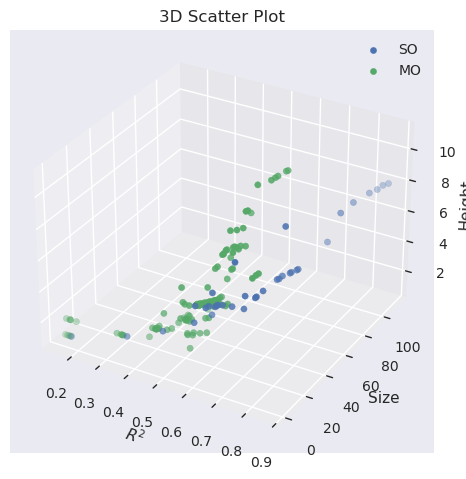

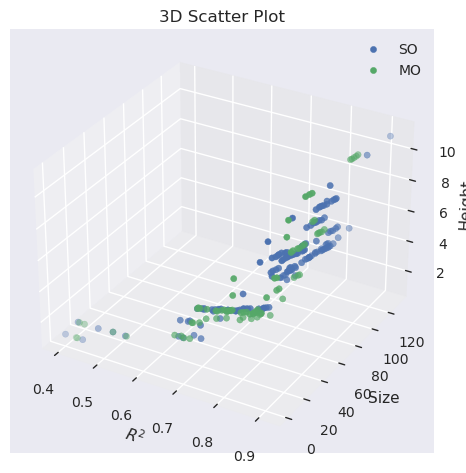

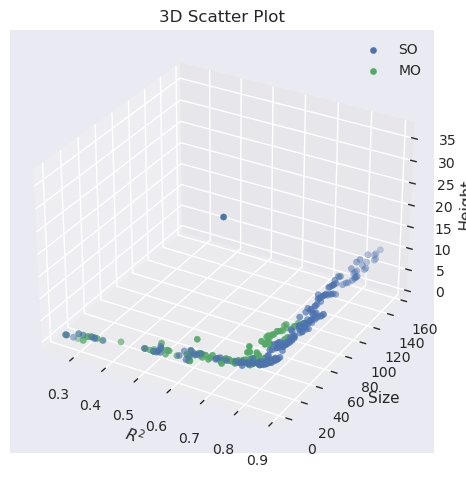

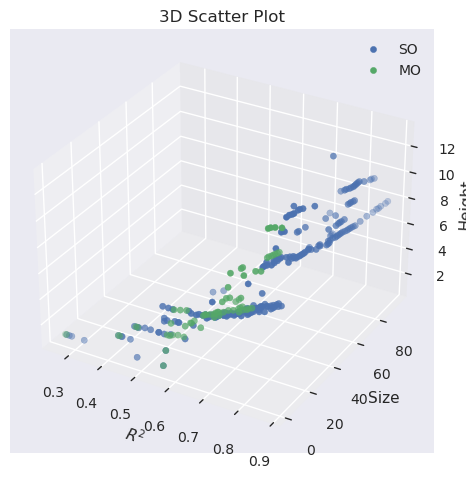

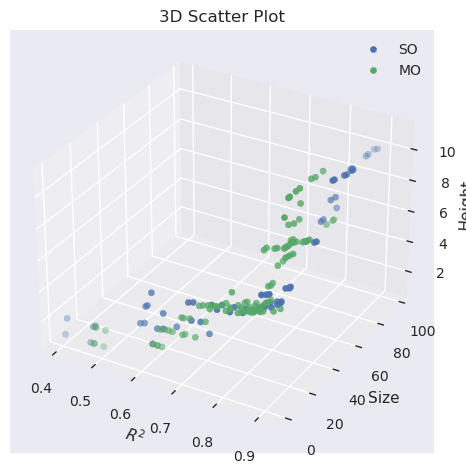

In [65]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# experiments = [["SO","MO"]]
# for dataset in datasets:
#     for experiment in experiments:
#         # Create a new figure for 3D plotting
#         fig = plt.figure()
#         ax = fig.add_subplot(111, projection='3d')
#         for algorithm in experiment:

#             # Sample data
#             x = dataset_filename[dataset][algorithm]["x"]
#             y = dataset_filename[dataset][algorithm]["y"]
#             z = dataset_filename[dataset][algorithm]["z"]



#             # Create a 3D scatter plot
#             ax.scatter(x, y, z, marker='o', label=algorithm)

#         # Customize the plot (optional)
#         ax.set_xlabel(r'$R^2$')
#         ax.set_ylabel('Size')
#         ax.set_zlabel('Height')
#         ax.set_title('3D Scatter Plot')
#         plt.legend()

#         # Show the plot
#         plt.show()

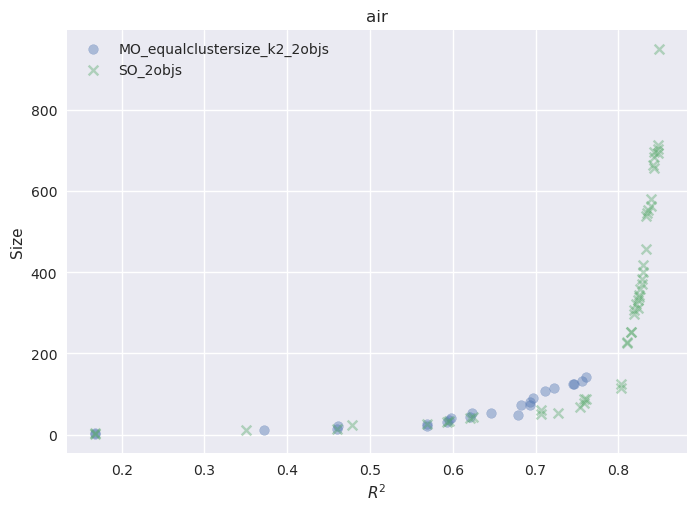

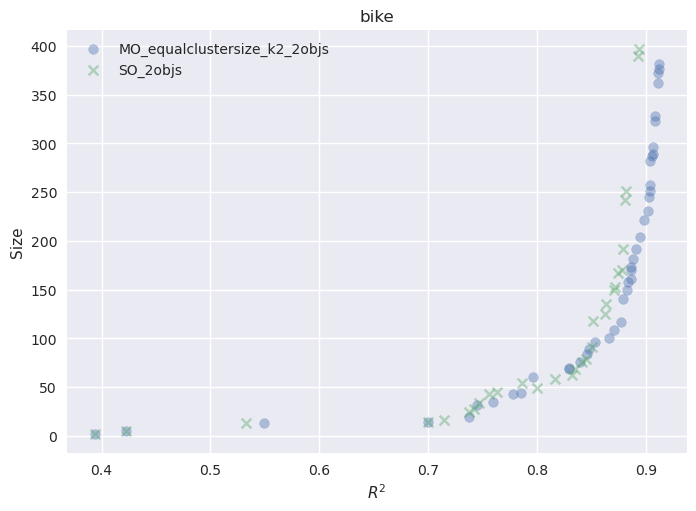

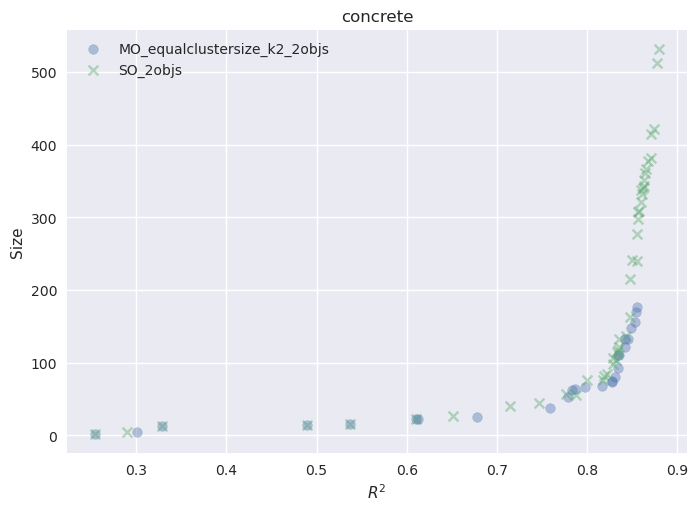

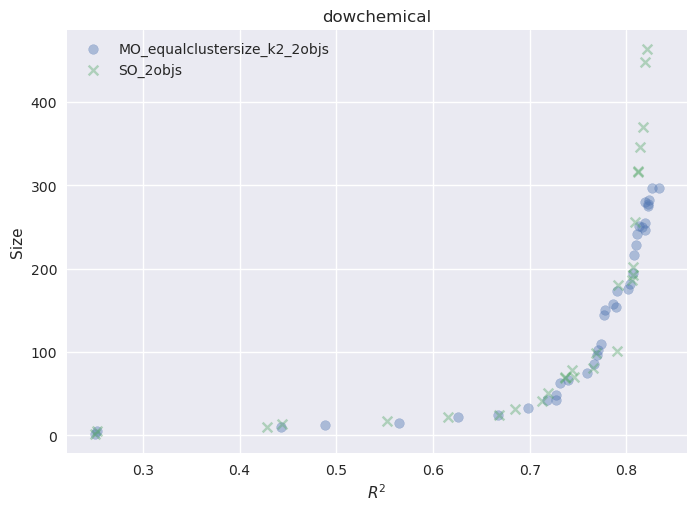

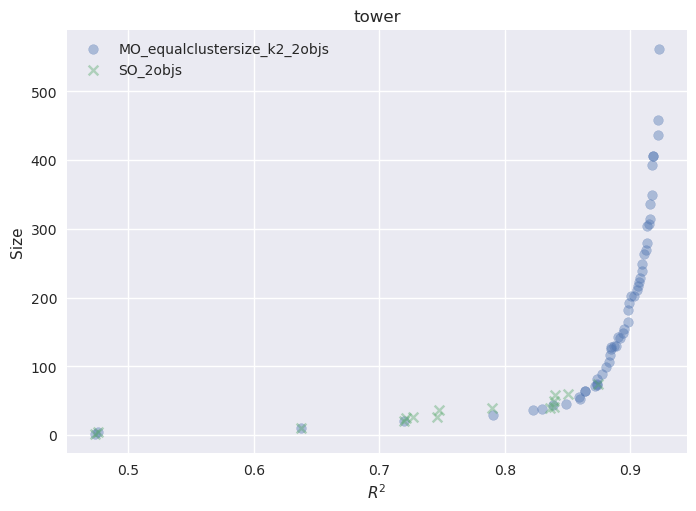

In [175]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

experiments = [["MO_equalclustersize_k2_sample_2objs", "SO_sample_2objs"]]
experiments = [["MO_equalclustersize_k2_2objs", "SO_2objs"]]
markers = ['o', 'x', '^','s']
for dataset in datasets:
    for experiment in experiments:
        # Create a new figure for 3D plotting
        plt.figure()

        for algorithm in experiment:

            # Sample data
            x = dataset_filename_2objs[dataset][algorithm]["x"]
            y = dataset_filename_2objs[dataset][algorithm]["z"]
            


            # Create a 3D scatter plot
            # plt.scatter(collapse_list(x), collapse_list(y), alpha=0.4, label=algorithm, marker=markers[experiment.index(algorithm)])
            plt.scatter(x[0], y[0], alpha=0.4, label=algorithm, marker=markers[experiment.index(algorithm)])

        # Customize the plot (optional)
        plt.xlabel(r'$R^2$')
        plt.ylabel('Size')
        plt.title(dataset)
        plt.legend()

        # Show the plot
        plt.show()
        

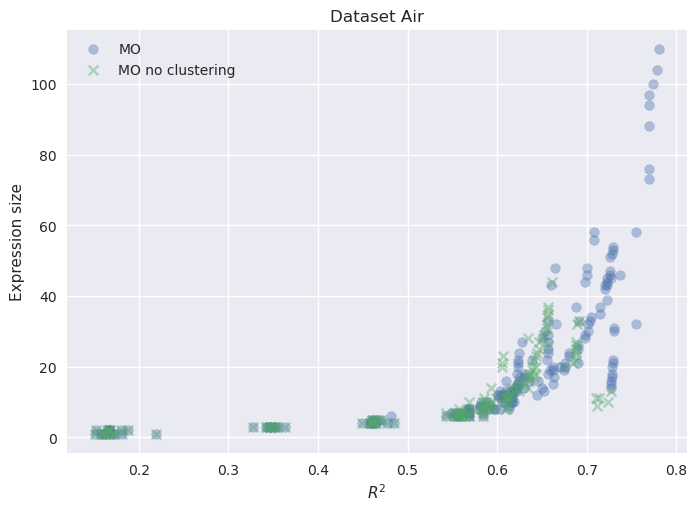

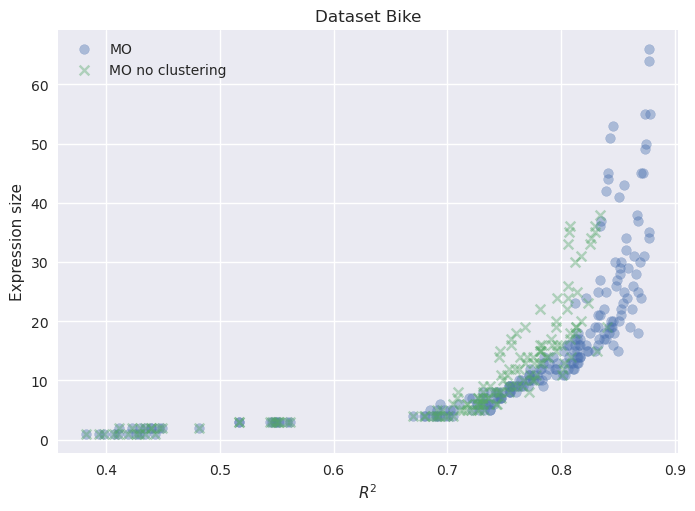

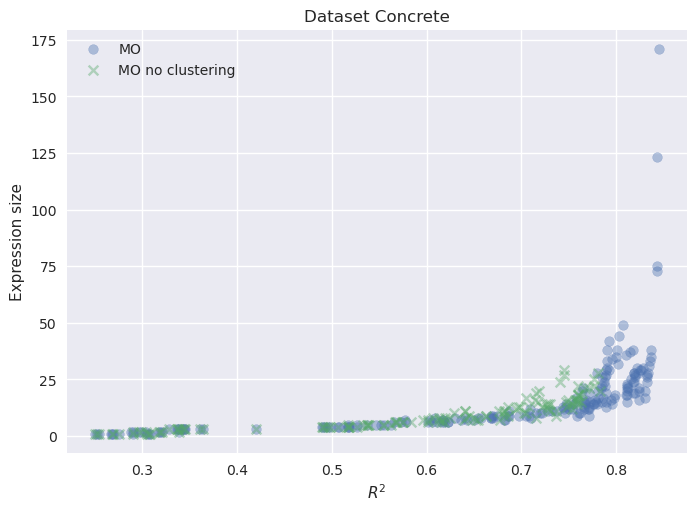

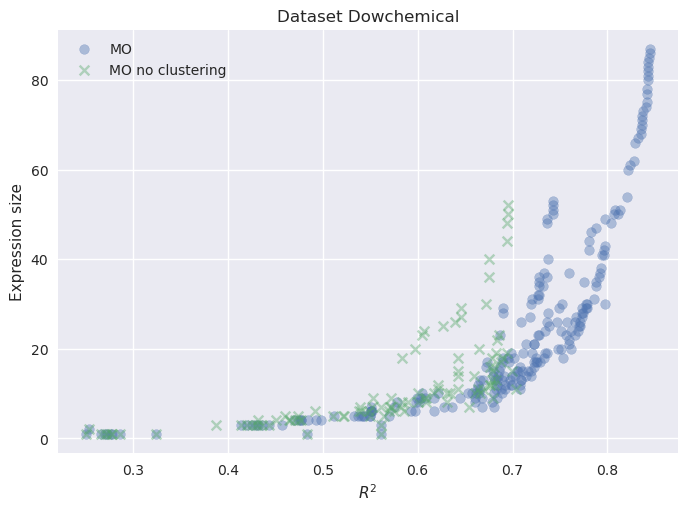

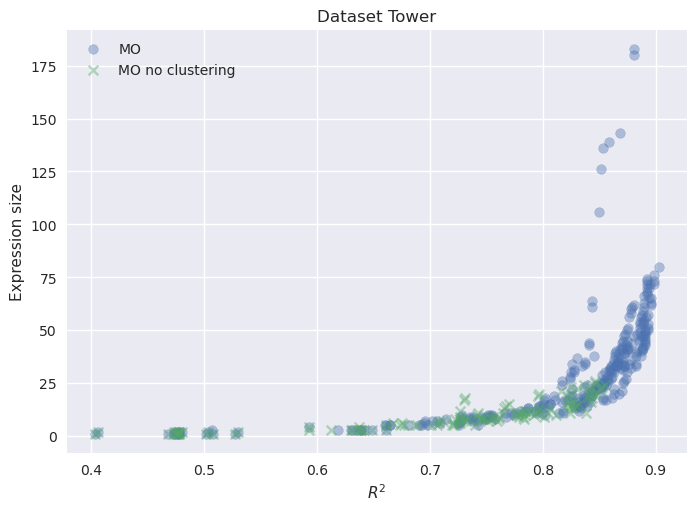

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

experiments = [["MO", "MO_nocluster"]]
translate_dict = {"MO":"MO", "MO_nocluster":"MO no clustering"}
markers = ['o', 'x', '^','s']
for dataset in datasets:
    for experiment in experiments:
        # Create a new figure for 3D plotting
        plt.figure()

        for algorithm in experiment:

            # Sample data
            x = dataset_filename[dataset][algorithm]["x"]
            y = dataset_filename[dataset][algorithm]["y"]
            
            

            # Create a 3D scatter plot
            plt.scatter(collapse_list(x), collapse_list(y), alpha=0.4, label=translate_dict[algorithm], marker=markers[experiment.index(algorithm)])

        # Customize the plot (optional)
        plt.xlabel(r'$R^2$')
        plt.ylabel('Expression size')
        plt.title("Dataset {}".format(dataset.capitalize()))
        plt.legend()

        # Show the plot
        plt.show()
        

(0.014110991344708279, 1.0, 1.0, 1, 569)
(0.3375612857742317, 15.0, 61.0, 0, 109)
(0.12392346451737346, 10.0, 35.0, 3, 124)
(0.3557757348421262, 8.0, 30.0, 3, 93)
(0.2025460209450638, 2.0, 10.0, 3, 129)
(0.014110991344708279, 1.0, 1.0, 1, 569)
(0.3375612857742317, 15.0, 61.0, 0, 109)
(0.12392346451737346, 10.0, 35.0, 3, 124)
(0.3557757348421262, 8.0, 30.0, 3, 93)
(0.2025460209450638, 2.0, 10.0, 3, 129)
(0.2025460209450638, 2.0, 10.0, 0, 108)
(0.13254098453458973, 2.0, 11.0, 3, 129)
(0.014110991344708279, 1.0, 1.0, 1, 581)
(0.26730516168949425, 2.0, 11.0, 3, 113)
(0.2877163818538745, 2.0, 9.0, 3, 93)
(0.2877163818538745, 2.0, 9.0, 0, 105)
(0.2877163818538745, 2.0, 9.0, 3, 103)
(0.5424605783465165, 8.0, 25.0, 3, 129)
(0.0, 1.0, 1.0, 1, 581)
(0.4032762250546811, 30.0, 95.0, 3, 106)
(0.4676516536167187, 21.0, 67.0, 0, 115)
(0.2877163818538745, 2.0, 9.0, 3, 113)
(0.48675561197874784, 18.0, 47.0, 3, 114)
(0.024351907422662467, 1.0, 2.0, 1, 581)
(0.2877163818538745, 2.0, 9.0, 3, 101)
(0.46765

(0.7543749642824402, 41.0, 120.0, 0, 203)
(0.024351907422662467, 1.0, 2.0, 1, 338)
(0.024351907422662467, 1.0, 2.0, 3, 155)
(0.7428055054454502, 10.0, 25.0, 3, 208)
(0.024351907422662467, 1.0, 2.0, 3, 120)
(0.024351907422662467, 1.0, 2.0, 3, 210)
(0.7591813131349356, 9.0, 31.0, 3, 138)
(0.7591813131349356, 9.0, 31.0, 0, 140)
(0.7591813131349356, 9.0, 31.0, 3, 133)
(0.024351907422662467, 1.0, 2.0, 1, 403)
(0.024351907422662467, 1.0, 2.0, 1, 407)
(0.7591813131349356, 9.0, 31.0, 0, 145)
(0.7591813131349356, 9.0, 31.0, 3, 122)
(0.26730516168949425, 1.0, 2.0, 3, 146)
(0.024351907422662467, 1.0, 2.0, 3, 204)
(0.7591813131349356, 9.0, 31.0, 0, 217)
(0.024351907422662467, 1.0, 2.0, 1, 325)
(0.024351907422662467, 1.0, 2.0, 3, 137)
(0.7591813131349356, 9.0, 31.0, 3, 193)
(0.024351907422662467, 1.0, 2.0, 3, 152)
(0.7591813131349356, 9.0, 31.0, 0, 205)
(0.024351907422662467, 1.0, 2.0, 1, 146)
(0.024351907422662467, 1.0, 2.0, 3, 338)
(0.7591813131349356, 9.0, 31.0, 3, 205)
(0.024351907422662467, 1.

(0.26730516168949425, 1.0, 2.0, 1, 205)
(0.7368142806484703, 17.0, 62.0, 0, 204)
(0.5772110883902606, 10.0, 27.0, 3, 205)
(0.5772110883902606, 10.0, 27.0, 3, 205)
(0.26730516168949425, 1.0, 2.0, 3, 205)
(0.7368142806484703, 17.0, 62.0, 0, 205)
(0.26730516168949425, 1.0, 2.0, 1, 205)
(1.0621006507616215e-07, 1.0, 1.0, 3, 204)
(0.5772110883902606, 10.0, 27.0, 3, 205)
(0.5772110883902606, 10.0, 27.0, 3, 205)
(0.26730516168949425, 1.0, 2.0, 1, 205)
(0.7368142806484703, 17.0, 62.0, 0, 204)
(0.5772110883902606, 10.0, 27.0, 3, 205)
(0.5772110883902606, 10.0, 27.0, 3, 205)
(0.6649171508742225, 23.0, 106.0, 3, 205)
(0.26730516168949425, 1.0, 2.0, 1, 205)
(0.26730516168949425, 1.0, 2.0, 0, 204)
(0.26730516168949425, 1.0, 2.0, 3, 205)
(0.26730516168949425, 1.0, 2.0, 3, 205)
(0.26730516168949425, 1.0, 2.0, 3, 205)
(0.26730516168949425, 1.0, 2.0, 1, 205)
(0.26730516168949425, 1.0, 2.0, 0, 205)
(0.26730516168949425, 1.0, 2.0, 3, 205)
(0.26730516168949425, 1.0, 2.0, 3, 205)
(0.26730516168949425, 1.0,

KeyboardInterrupt: 

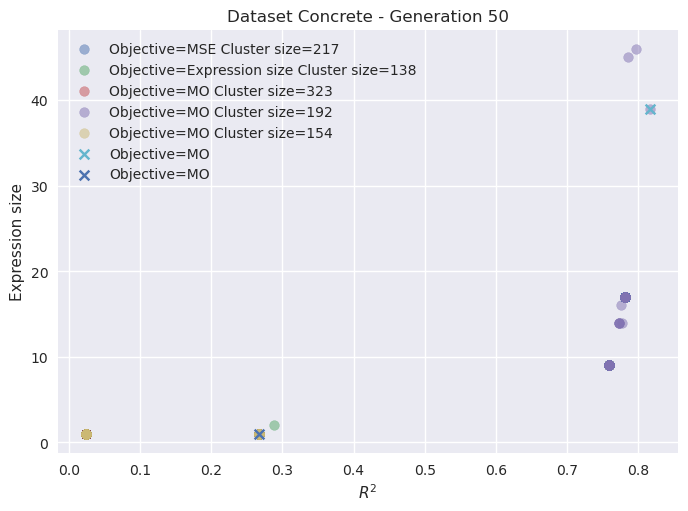

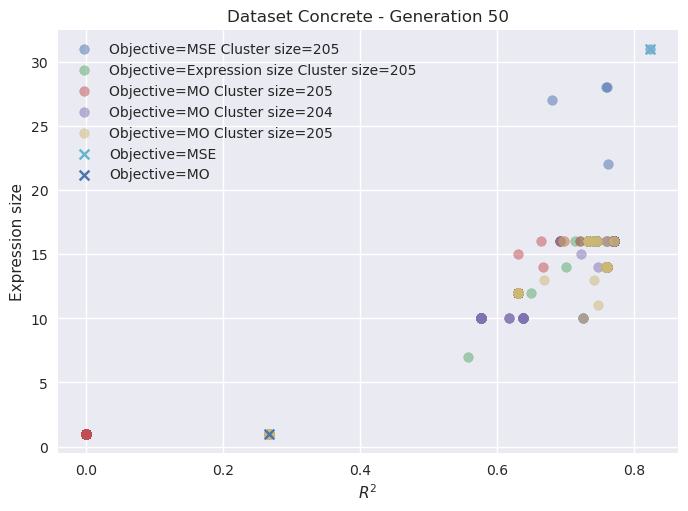

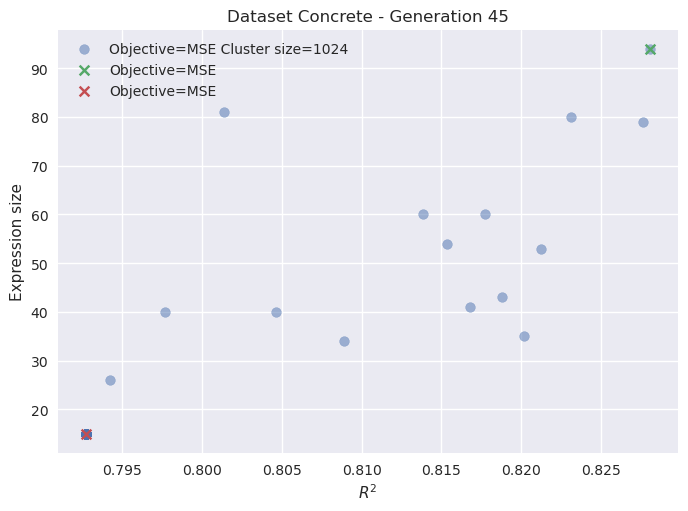

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import pandas as pd
import numpy as np
from matplotlib.animation import FuncAnimation
import glob
import traceback




# plt.style.use('seaborn')
import os

def read_tsv_file(file_path):
    try:
        # Read the TSV file into a pandas DataFrame
        df = pd.read_csv(file_path, header=None, sep='\t')
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")


def process_row(row, max_mse, max_len, max_complexity, df_var, data, update_max=False, grid=False):
    coordinates = []
    # Split each long line by ';' to get individual coordinate strings
    coordinate_strings = row[0].split(';')
    for coord_str in coordinate_strings:
        # Split each coordinate string by ',' to get x, y, z values
        if(grid):
            x, y, z, z1, z2, z3, _ = coord_str.replace("inf","-1").split(',')
            coordinates.append((float(x), float(y), float(z), float(z1), float(z2), float(z3)))
        else:
            x, y, z, z1, z2, z3 = coord_str.replace("inf","-1").split(',')
            if x!="-1":
                x = (1. - float(x)/float(df_var))
            coordinates.append((max(float(x),0.), float(y), float(z), int(z1), int(z2), int(z3)))



        if update_max:
            if 1. - float(x)/float(df_var)<max_mse and int(float(x)) !=-1:
                max_mse = 1. - float(x)/float(df_var)
            if float(y)>max_len and int(float(x))!=-1:
                max_len = float(y)
            if float(z)>max_complexity and int(float(x))!=-1:
                max_complexity = float(z)

    data.append(coordinates)
    return max_mse, max_len, max_complexity

def process_rows(df, df_var):
    # initialise maxes to 0
    max_len = 0
    max_mse = 0
    max_complexity = 0
    processed_data = []
    processed_cluster_data = []
    processed_donor_data = []
    processed_front_data = []
    processed_minmax = []
    
    
    for index, row in df.iterrows():
        # fitness mse, fitness size, fitness kommenda, cluster_id, cluster type, cluster size
        # Population
        if index%5==0:
            max_mse, max_len, max_complexity = process_row(row, max_mse, max_len, max_complexity, df_var, processed_data, update_max=True)
        # Clustered Population
        if index%5==1:
            process_row(row, max_mse, max_len, max_complexity, df_var, processed_cluster_data, update_max=True)
        # Clustered Donors
        if index%5==2:
            process_row(row, max_mse, max_len, max_complexity, df_var, processed_donor_data, update_max=True)
        # Archive
        if index%5==3:
            process_row(row, max_mse, max_len, max_complexity, df_var, processed_front_data, update_max=True)
        # Grid min maxes
        if index%5==4:
            process_row(row, max_mse, max_len, max_complexity, df_var, processed_minmax, update_max=False, grid=True)

    return processed_data, processed_cluster_data, processed_donor_data, processed_front_data, processed_minmax, max_len, max_mse, max_complexity


def update(frame):
    # With 2 objs 3 is MO and with 3 objs 4 is MO
    obj_names = {0:"MSE", 1:"Expression size", 2:"complexity", 3:"MO", 4:"MO", -1:"None"}
    ax.clear()

    best_mse_ind = (0,999999,999999,-1)
    best_size_ind = (0,999999,999999,-1)
    best_complexity_ind = (0,999999,999999,-1)

    row = data[frame]



    # min_0, min_1, max_0, max_1, num_box = minmax[frame][0]
    # linspace_0 = np.linspace(min_0,max_0,num_box)
    #
    # for vline in linspace_0:
    #     plt.axvline(x = vline, color = 'b', linestyle='dashed', alpha=0.5)
    #
    # linspace_1 = np.linspace(min_1,max_1,num_box)
    #
    # for hline in linspace_1:
    #     plt.axhline(y = hline, color = 'b', linestyle='dashed', alpha=0.5)

    sorted_by_z = [[],[],[],[],[],[],[]]

    for coord in row:


      x = float(str(coord[0]).replace("-1.0", str(max_mse)))  
      y = float(str(coord[1]).replace("-1.0", str(max_len)))
      z = float(str(coord[2]).replace("-1.0", str(max_complexity)))
      sorted_by_z[coord[3]].append((x, y, z, coord[4], coord[5]))


    x_idx = 0
    y_idx = 1

    for z_val, row in enumerate(sorted_by_z):
      if(len(row)>0):
          x_vals = [coord[x_idx] for coord in row]
          y_vals = [coord[y_idx] for coord in row]
          
          print(row[0])
          #Cluster id={z_val} 
          ax.scatter(x_vals, y_vals, label=f'Objective={obj_names[int(row[0][3])]} Cluster size={row[0][4]}', alpha=0.5)

          for coord in row:
              if coord[0]>best_mse_ind[0]:
                best_mse_ind = (coord[0],coord[1],coord[2],z_val,row[0][3],row[0][4])
              if coord[1]<=best_size_ind[1]:
                best_size_ind = (coord[0],coord[1],coord[2],z_val,row[0][3],row[0][4])
              if coord[2]<best_complexity_ind[2]:
                  best_complexity_ind = (coord[0],coord[1],coord[2],z_val,row[0][3],row[0][4])

    # ax.set_ylim(0,200)
    # ax.set_xlim(0,4000)


    ax.scatter(best_mse_ind[x_idx],best_mse_ind[y_idx],marker='x', label=f'Objective={obj_names[int(best_mse_ind[4])]}')
    ax.scatter(best_size_ind[x_idx],best_size_ind[y_idx],marker='x', label=f'Objective={obj_names[int(best_size_ind[4])]}')
    #ax.scatter(best_complexity_ind[x_idx],best_complexity_ind[y_idx],marker='x', label=f'Cluster id={best_complexity_ind[4]}, Objective={obj_names[int(best_complexity_ind[4])]}')



    idx_to_label = {0:r"$R^2$", 1:"Expression size", 2:"Complexity"}

    ax.set_xlabel(idx_to_label[x_idx])
    ax.set_ylabel(idx_to_label[y_idx])
    ax.set_title(f'Dataset Concrete - Generation {frame+1}')
    ax.legend()


def update2(frame):
    obj_names = {0:"MSE", 1:"size", 3:"MO", -1:"None"}
    ax.clear()

    colors = ['b','g','r','c','m','y','k']

    row = data[frame]

    sorted_by_z = [[],[],[],[],[],[],[]]

    for coord in row:
      x = float(str(coord[0]).replace("-1.0", str(0.)))  
      y = float(str(coord[1]).replace("-1.0", str(max_len)))  
      sorted_by_z[coord[2]].append((x, y, coord[3], coord[4]))

    for z_val, row in enumerate(sorted_by_z):
      if(len(row)>0):
          x_vals = [coord[0] for coord in row]
          y_vals = [coord[1] for coord in row]
          ax.scatter(x_vals, y_vals, label=f'Cluster id={z_val} objective={obj_names[int(row[0][2])]} Cluster size={row[0][3]}', alpha=0.5, marker="x", color=[colors[z_val]])

    row = data2[frame]
    sorted_by_z = [[],[],[],[],[],[],[]]

    for coord in row:
      x = float(str(coord[0]).replace("-1.0", str(max_mse)))  
      y = float(str(coord[1]).replace("-1.0", str(max_len)))  
      sorted_by_z[coord[2]].append((x, y, coord[3], coord[4]))

    for z_val, row in enumerate(sorted_by_z):
      if(len(row)>0):
          x_vals = [coord[0] for coord in row]
          y_vals = [coord[1] for coord in row]
          if(z_val == 2):
            ax.scatter(x_vals, y_vals, label=f'Cluster # {z_val} objective={obj_names[int(row[0][2])]} Cluster size={row[0][3]}', alpha=0.2, marker="o", color=[colors[z_val]])
    
    
    
    ax.set_xlabel('MSE')
    ax.set_ylabel('Expression size')
    ax.set_title(f'Generation {frame+1}')
    ax.legend()    


def make_frames(data, folder, title):
    global ax
    fig, ax = plt.subplots()
    

    ani = FuncAnimation(fig, update, frames=50, interval=1000)

    directory = f'./frames/{folder}'
    isExist = os.path.exists(directory)
    if not isExist:
        os.makedirs(directory)

    for i in range(len(data)):
        update(i)
        plt.savefig(f'{directory}/{title}_{i:04d}.png',dpi=600,bbox_inches="tight")

def make_frames2(data, data2, folder, title):
    global ax
    fig, ax = plt.subplots()

    ani = FuncAnimation(fig, update2, frames=len(data), interval=1000)

    directory = f'./frames/{folder}'
    isExist = os.path.exists(directory)
    if not isExist:
        os.makedirs(directory)

    for i in range(len(data)):
        update2(i)
        plt.savefig(f'{directory}/{title}_{i:04d}.png',dpi=600,bbox_inches="tight")

def rreplace(s, old, new, occurrence):
    li = s.rsplit(old, occurrence)
    return new.join(li)

# Iterate over designated runs with logpop turned on.
for filename in ["./results/joecomplexity/pop/11_MO_concrete.csv", "./results/joecomplexity/pop/11_MO_balanced_concrete.csv", "./results/joecomplexity/pop/11_SO_concrete.csv", "./results/joecomplexity/pop/11_MO_k2_concrete.csv", "./results/joecomplexity/pop/11_MO_equalclustersize_balanced_sample.csv"]:
    # Each file gets its own folder 11_MO_balanced_concrete.csv -> MO_balanced_concrete
    folder = filename.split("/")[-1][3:-4]
    # Get valiadation variance from other file
    df_var = pd.read_csv(filename.replace("/pop/","/"),header=None, sep="\t").iloc[-1][7]
    
    df = read_tsv_file(filename)

    try:
        # population, cluster, donor clusters, front, min max of grid
        processed_data, processed_cluster_data, processed_donor_data, processed_front_data, processed_minmax, max_len, max_mse, max_complexity = process_rows(df, df_var)

        # Limit to n generations
        n_gens = 50
        data = processed_front_data[:n_gens]
        
        minmax = processed_minmax
#         make_frames(data, folder, "front")

        data = processed_cluster_data[:n_gens]
        make_frames(data, folder, "pop")
    #
    # data = processed_cluster_data
    # data2 = processed_donor_data
    # make_frames2(data, data2, folder, "donors")
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        pass




In [10]:
!ls ./results/joecomplexity/11*
# DO FRAC1 too

./results/joecomplexity/11_MO_balanced_concrete.csv
./results/joecomplexity/11_MO_concrete.csv
./results/joecomplexity/11_MO_equalclustersize_balanced_sample_concrete.csv
./results/joecomplexity/11_MO_k2_concrete.csv
./results/joecomplexity/11_SO_concrete.csv


In [24]:
!ls ./results/joecomplexity/*2objs*

./results/joecomplexity/2_MO_equalclustersize_balanced_frac1_2objs_air.csv
./results/joecomplexity/2_SO_2objs_concrete.csv
./results/joecomplexity/7_MO_equalclustersize_balanced_frac1_2objs_air.csv
./results/joecomplexity/7_SO_2objs_dowchemical.csv
